Chargement du fichier data/matrice_routes_ordre.csv...

Paramètres du problème:
- Nombre de villes: 50
- Points de collecte: [44, 36]
- Taille de la matrice: (50, 50)
Iter 100: Temp=6057.70 Best=4312 Current=4597
Iter 200: Temp=3669.58 Best=4030 Current=4670
Iter 300: Temp=2222.92 Best=4030 Current=5222
Iter 400: Temp=1346.58 Best=4030 Current=4801
Iter 500: Temp=815.72 Best=4030 Current=4618
Iter 600: Temp=494.14 Best=4030 Current=5005
Iter 700: Temp=299.33 Best=4030 Current=4563
Iter 800: Temp=181.33 Best=4030 Current=5386
Iter 900: Temp=109.84 Best=3487 Current=3557
Iter 1000: Temp=66.54 Best=2767 Current=2928
Iter 1100: Temp=40.31 Best=2543 Current=2547
Iter 1200: Temp=24.42 Best=2214 Current=2214
Iter 1300: Temp=14.79 Best=1810 Current=1810
Iter 1400: Temp=8.96 Best=1745 Current=1745
Iter 1500: Temp=5.43 Best=1700 Current=1700
Iter 1600: Temp=3.29 Best=1641 Current=1641
Iter 1700: Temp=1.99 Best=1611 Current=1611
Iter 1800: Temp=1.21 Best=1557 Current=1557
Iter 1900: Temp=0.73 Bes

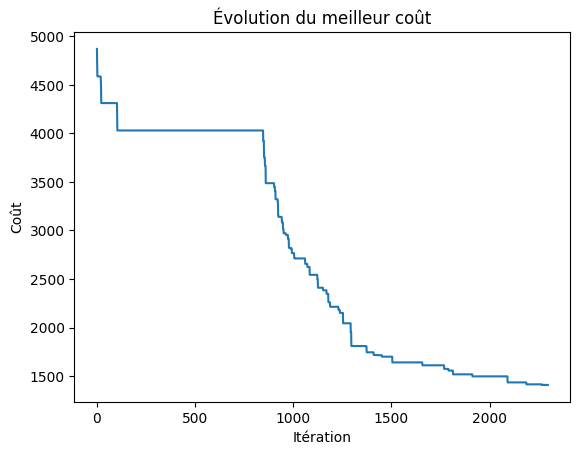


Meilleur chemin trouvé (extrait):
Départ: [1, 44, 21]...[32, 40, 1]
Longueur: 51 villes
Coût total: 1409


In [2]:
import random
import numpy as np
from typing import List, Tuple, Set
import time
import matplotlib.pyplot as plt
import math

def load_adjacency_matrix_and_collecte(file_path: str) -> Tuple[np.ndarray, List[int]]:
    """Charge la matrice d'adjacence et les points de collecte depuis un fichier CSV."""
    try:
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        
        # Dernière ligne contient les points de collecte
        points_collecte = list(map(int, lines[-1].split(';')))
        
        # Matrice d'adjacence dans les autres lignes
        matrix = []
        for line in lines[:-1]:
            row = list(map(int, line.split(';')))
            matrix.append(row)
            
        return np.array(matrix), points_collecte
        
    except FileNotFoundError:
        raise ValueError(f"Fichier {file_path} introuvable")
    except Exception as e:
        raise ValueError(f"Erreur lors de la lecture du fichier: {str(e)}")

class SimulatedAnnealingTSP:
    def __init__(self, matrix: np.ndarray, collecte_points: List[int], start_node: int = 1):
        self.matrix = matrix
        self.collecte = set(collecte_points)
        self.start_node = start_node
        self.num_cities = len(matrix)
        self.best_solution = None
        self.best_cost = float('inf')
        self.cost_history = []
        
        # Pré-calcul des villes accessibles depuis chaque ville
        self.accessible_from = {
            i: [j for j in range(1, self.num_cities+1) if matrix[i-1][j-1] != -1]
            for i in range(1, self.num_cities+1)
        }
        
        # Validation des entrées
        self._validate_inputs()
    
    def _validate_inputs(self):
        if len(self.matrix.shape) != 2 or self.matrix.shape[0] != self.matrix.shape[1]:
            raise ValueError("La matrice d'adjacence doit être carrée")
        if self.start_node < 1 or self.start_node > self.num_cities:
            raise ValueError(f"Le noeud de départ doit être entre 1 et {self.num_cities}")
        if not self.collecte:
            raise ValueError("Aucun point de collecte spécifié")

    def is_valid_path(self, path: List[int]) -> bool:
        """Vérifie si un chemin satisfait toutes les contraintes."""
        # Vérification basique
        if (len(path) != self.num_cities + 1 or 
            path[0] != self.start_node or 
            path[-1] != self.start_node):
            return False
            
        # Points de collecte
        if path[1] not in self.collecte or path[-2] in self.collecte:
            return False
            
        # Toutes villes visitées exactement une fois (sauf départ/arrivée)
        if len(set(path)) != self.num_cities:
            return False
            
        # Chemins valides
        for i in range(len(path)-1):
            if self.matrix[path[i]-1][path[i+1]-1] == -1:
                return False
                
        return True

    def calculate_cost(self, path: List[int]) -> int:
        """Calcule le coût total d'un chemin."""
        return sum(self.matrix[path[i]-1][path[i+1]-1] for i in range(len(path)-1))

    def _greedy_construction(self) -> List[int]:
        """Construit une solution initiale avec une approche gloutonne en respectant les contraintes."""
        path = [self.start_node]
        unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
        
        # Premier mouvement vers le point de collecte le plus proche
        collect_candidates = [c for c in self.collecte if c in unvisited and 
                            self.matrix[self.start_node-1][c-1] != -1]
        if not collect_candidates:
            return None
            
        nearest_collect = min(collect_candidates, 
                            key=lambda x: self.matrix[self.start_node-1][x-1])
        path.append(nearest_collect)
        unvisited.remove(nearest_collect)
        
        # Construction gloutonne du chemin
        while unvisited:
            last = path[-1]
            
            # Filtrer les villes accessibles non visitées
            candidates = [c for c in self.accessible_from[last] if c in unvisited]
            
            if not candidates:
                # Si aucun candidat valide, essayer de trouver un chemin valide
                candidates = list(unvisited)
                random.shuffle(candidates)
                
            # Sélectionner la ville la plus proche accessible
            next_city = None
            min_dist = float('inf')
            for c in candidates:
                if self.matrix[last-1][c-1] < min_dist and self.matrix[last-1][c-1] != -1:
                    min_dist = self.matrix[last-1][c-1]
                    next_city = c
            
            if next_city is None:
                return None
                
            path.append(next_city)
            unvisited.remove(next_city)
        
        # Retour au point de départ
        if self.matrix[path[-1]-1][self.start_node-1] == -1:
            return None
            
        path.append(self.start_node)
        
        return path if self.is_valid_path(path) else None

    def generate_random_solution(self) -> List[int]:
        """Génère une solution aléatoire valide."""
        while True:
            path = [self.start_node]
            unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
            
            # Ajout d'un point de collecte en deuxième position
            collect_candidates = [c for c in self.collecte if c in unvisited and 
                                self.matrix[self.start_node-1][c-1] != -1]
            if not collect_candidates:
                continue
                
            collect_point = random.choice(collect_candidates)
            path.append(collect_point)
            unvisited.remove(collect_point)
            
            # Construction aléatoire mais valide du chemin
            while unvisited:
                last = path[-1]
                candidates = [c for c in self.accessible_from[last] if c in unvisited]
                
                if not candidates:
                    break
                    
                next_city = random.choice(candidates)
                path.append(next_city)
                unvisited.remove(next_city)
            
            # Retour au départ si possible
            if unvisited or self.matrix[path[-1]-1][self.start_node-1] == -1:
                continue
                
            path.append(self.start_node)
            
            if self.is_valid_path(path):
                return path

    def get_neighbor(self, path: List[int]) -> List[int]:
        """Génère un voisin valide de la solution actuelle."""
        while True:
            new_path = path.copy()
            
            # On ne modifie pas le départ, l'arrivée ou les points de collecte contraints
            mutable_positions = list(range(1, len(path)-1))
            if len(path) > 3:
                mutable_positions.remove(1)  # Ne pas muter le premier point de collecte
            if len(path) > 4:
                mutable_positions.remove(len(path)-2)  # Ne pas muter l'avant-dernier point
                
            if len(mutable_positions) < 2:
                return path
                
            # Choisir un type de mouvement aléatoire
            move_type = random.choice(['swap', 'inversion', 'insertion'])
            
            if move_type == 'swap':
                # Échange de deux villes
                i, j = random.sample(mutable_positions, 2)
                new_path[i], new_path[j] = new_path[j], new_path[i]
                
            elif move_type == 'inversion':
                # Inversion d'une sous-séquence
                start, end = sorted(random.sample(mutable_positions, 2))
                new_path[start:end+1] = new_path[start:end+1][::-1]
                
            elif move_type == 'insertion':
                # Déplacement d'une ville à une autre position
                i = random.choice(mutable_positions)
                city = new_path.pop(i)
                j = random.choice([p for p in mutable_positions if p != i])
                new_path.insert(j, city)
            
            # Vérifier si le nouveau chemin est valide
            if self.is_valid_path(new_path):
                return new_path

    def solve(self, initial_temp: float = 10000, cooling_rate: float = 0.99,
             min_temp: float = 0.1, max_iter: int = 10000):
        """Algorithme de recuit simulé."""
        start_time = time.time()
        
        # Génération de la solution initiale
        current_solution = self._greedy_construction() or self.generate_random_solution()
        current_cost = self.calculate_cost(current_solution)
        
        self.best_solution = current_solution.copy()
        self.best_cost = current_cost
        self.cost_history.append(current_cost)
        
        temp = initial_temp
        iteration = 0
        
        while temp > min_temp and iteration < max_iter:
            # Générer un voisin
            neighbor = self.get_neighbor(current_solution)
            neighbor_cost = self.calculate_cost(neighbor)
            
            # Calculer la différence de coût
            cost_diff = neighbor_cost - current_cost
            
            # Accepter ou rejeter le voisin
            if cost_diff < 0 or random.random() < math.exp(-cost_diff / temp):
                current_solution = neighbor
                current_cost = neighbor_cost
                
                # Mettre à jour la meilleure solution
                if current_cost < self.best_cost:
                    self.best_solution = current_solution.copy()
                    self.best_cost = current_cost
            
            # Enregistrer le meilleur coût à chaque itération
            self.cost_history.append(self.best_cost)
            
            # Refroidissement
            temp *= cooling_rate
            iteration += 1
            
            # Affichage progression
            if iteration % 100 == 0:
                print(f"Iter {iteration}: Temp={temp:.2f} Best={self.best_cost} Current={current_cost}")
        
        print(f"\nOptimisation terminée en {time.time()-start_time:.2f}s")
        print(f"Meilleur coût trouvé: {self.best_cost}")
        print(f"Solution valide: {self.is_valid_path(self.best_solution)}")
        
        # Visualisation
        plt.plot(self.cost_history)
        plt.title("Évolution du meilleur coût")
        plt.xlabel("Itération")
        plt.ylabel("Coût")
        plt.show()
        
        return self.best_solution, self.best_cost

# Exemple d'utilisation avec votre lecture de fichier
if __name__ == "__main__":
    try:
        file_path = "data/matrice_routes_ordre.csv"  # Remplacez par votre chemin
        print(f"Chargement du fichier {file_path}...")
        matrix, collecte = load_adjacency_matrix_and_collecte(file_path)
        
        print("\nParamètres du problème:")
        print(f"- Nombre de villes: {len(matrix)}")
        print(f"- Points de collecte: {collecte}")
        print(f"- Taille de la matrice: {matrix.shape}")
        
        # Résolution
        solver = SimulatedAnnealingTSP(matrix, collecte)
        solution, cost = solver.solve(
            initial_temp=10000,
            cooling_rate=0.995,
            min_temp=0.1,
            max_iter=5000
        )
        
        print("\nMeilleur chemin trouvé (extrait):")
        print(f"Départ: {solution[:3]}...{solution[-3:]}")
        print(f"Longueur: {len(solution)} villes")
        print(f"Coût total: {cost}")
        
    except Exception as e:
        print(f"Erreur: {str(e)}")